Brandon Rose  12:58 PM
@Matt Printz for the Refuge Routes Model here’s what I’m thinking:
The model should take in a conflict/disaster location (more on this later) which is lat/lon + disaster_radius (the radius impacted from the point in km)
We use GeoNames to identify cities and towns greater than a population parameter threshold outside the disaster_radius but inside the flight_radius (this could default to disaster_radius + 500km or something like that. This yields n possible flight locations.
Next, we use Google Directions API (more on this later) to get the directions from the disaster location to each of the n possible flight locations. We default to driving directions but allow the user to specify walking as a parameter too if desired. We sort these by travel duration.
The results would be an interactive map like we showed Anish as well as a CSV that contains 1 row per flight location and includes lat/lon for that location, population size, duration in minutes from disaster, distance in km from disaster.
Location: we should start with point/radius but could expand to allow for a bounding box instead.
API key: we should lock down the API key (in Google Developer Console) to just DMC IP for now

In [94]:
import os

import geopandas as gpd
import pandas as pd
import math
import numpy as np
import shapely
import googlemaps
import pgeocode
import pyproj

In [4]:
start_lat, start_lon = (30.270, -97.743)
disaster_radius_km = 150
flight_radius_km = disaster_radius_km + 100
travel_modes = ["DRIVING", "WALKING"]
travel_mode = travel_modes[0]

In [ ]:
googlemaps_key = os.environ.get("GOOGLEMAPS_KEY")

http://www.geonames.org/

In [ ]:
gmaps = googlemaps.Client(key=googlemaps_key)

In [47]:
def reverse_haversine(start_location, dist_km, direction="N"):
    dir_lookup = {
        "N": 0,
        "E": math.pi/2,
        "S": math.pi,
        "W": -math.pi/2,
    }
    result = np.radians(start_location)
    lat, long = result
    dist = dist_km / pgeocode.EARTH_RADIUS
    theta = dir_lookup[direction]  # Direction in radians
    
    lat2 = math.asin(
        (math.sin(lat) * math.cos(dist)) + (math.cos(lat) * math.sin(dist) * math.cos(theta))
    )
    long2 = (
        long + math.atan2((math.sin(theta) * math.sin(dist) * math.cos(lat)),
        (math.cos(dist) - (math.sin(lat) * math.sin(lat2))))
    )
    
    return math.degrees(lat2), math.degrees(long2)
reverse_haversine((start_lat, start_lon), 50, "W")

(30.26897017206283, -98.26364149097161)

In [53]:
loc = (start_lat, start_lon)
bounds = {
    "north": reverse_haversine(loc, flight_radius_km, "N")[0], 
    "east": reverse_haversine(loc, flight_radius_km, "E")[1],
    "south": reverse_haversine(loc, flight_radius_km, "S")[0], 
    "west": reverse_haversine(loc, flight_radius_km, "W")[1],
}
bounds

{'north': 32.51830083873222,
 'east': -95.14022921192421,
 'south': 28.021699161267772,
 'west': -100.34577078807577}

In [50]:
bounds

[(-2.2483008387322236, 2.602770788075773),
 (58.29169916126777, -2.6027707880757873)]

https://download.geonames.org/export/dump/cities1000.zip
http://download.geonames.org/export/dump/readme.txt

In [54]:
CITY_FILE = "cities1000.txt"

In [66]:
city_df = pd.read_csv(
    CITY_FILE, 
    sep="\t", 
    header=0,
    names=[
         "geonameid", 
 "name", 
 "asciiname", 
 "alternatenames", 
 "latitude", 
 "longitude", 
 "feature class", 
 "feature code", 
 "country code", 
 "cc2", 
 "admin1 code", 
 "admin2 code", 
 "admin3 code", 
 "admin4 code", 
 "population", 
 "elevation", 
 "dem", 
 "timezone", 
 "modification date", 

    ]
)

/tmp/ipykernel_150171/2045376136.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.read_csv(


In [67]:
city_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date
0,3039163,Sant Julià de Lòria,Sant Julia de Loria,"San Julia,San Julià,Sant Julia de Loria,Sant J...",42.46372,1.49129,P,PPLA,AD,NaN,06,NaN,NaN,NaN,8022,NaN,921,Europe/Andorra,2013-11-23
1,3039604,Pas de la Casa,Pas de la Casa,"Pas de la Kasa,Пас де ла Каса",42.54277,1.73361,P,PPL,AD,NaN,03,NaN,NaN,NaN,2363,2050.0,2106,Europe/Andorra,2008-06-09
2,3039678,Ordino,Ordino,"Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...",42.55623,1.53319,P,PPLA,AD,NaN,05,NaN,NaN,NaN,3066,NaN,1296,Europe/Andorra,2018-10-26
3,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414,P,PPLA,AD,NaN,08,NaN,NaN,NaN,15853,NaN,1033,Europe/Andorra,2008-10-15
4,3040132,la Massana,la Massana,"La Macana,La Massana,La Maçana,La-Massana,la M...",42.54499,1.51483,P,PPLA,AD,NaN,04,NaN,NaN,NaN,7211,NaN,1245,Europe/Andorra,2008-10-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139469,895269,Beitbridge,Beitbridge,"Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be...",-22.21667,30.00000,P,PPL,ZW,NaN,07,NaN,NaN,NaN,26459,NaN,461,Africa/Harare,2013-03-12
139470,895308,Beatrice,Beatrice,Beatrice,-18.25283,30.84730,P,PPL,ZW,NaN,04,NaN,NaN,NaN,1647,NaN,1307,Africa/Harare,2018-05-09
139471,895417,Banket,Banket,"Banket,Banket Junction",-17.38333,30.40000,P,PPL,ZW,NaN,05,NaN,NaN,NaN,9641,NaN,1277,Africa/Harare,2013-03-12
139472,1085510,Epworth,Epworth,Epworth,-17.89000,31.14750,P,PPLX,ZW,NaN,10,NaN,NaN,NaN,123250,NaN,1508,Africa/Harare,2012-01-19


In [72]:
city_df.shape

(139474, 19)

In [80]:
q = f"not (latitude > {bounds['north']} or longitude > {bounds['east']} or latitude < {bounds['south']} or longitude < {bounds['west']})"
print(q)
cities_in_bounds_df = city_df.query(q)
cities_in_bounds_df.shape

not (latitude > 32.51830083873222 or longitude > -95.14022921192421 or latitude < 28.021699161267772 or longitude < -100.34577078807577)


(423, 19)

In [82]:
cities_in_bounds_df.sort_values("population")

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date
125925,4670732,Anderson,Anderson,"Anderson,andrsn tgzas,andrswn,Андерсон,أندرسو...",30.48715,-95.98690,P,PPLA2,US,NaN,TX,185,NaN,NaN,229,105.0,110,America/Chicago,2017-03-09
126685,4736889,Tilden,Tilden,"Colfax,Dog Town,Tilden",28.46194,-98.54918,P,PPLA2,US,NaN,TX,311,NaN,NaN,261,76.0,79,America/Chicago,2011-05-14
126484,4717199,Paint Rock,Paint Rock,"Paint Rock,Paintrock",31.50849,-99.92008,P,PPLA2,US,NaN,TX,095,NaN,NaN,266,497.0,499,America/Chicago,2017-03-09
126352,4705702,Leakey,Leakey,NaN,29.72884,-99.76145,P,PPLA2,US,NaN,TX,385,NaN,NaN,424,489.0,494,America/Chicago,2017-03-09
125948,4672171,Bandera,Bandera,"Bandera,bandyra,bndra tgzas,Бандера,بانديرا,ب...",29.72661,-99.07365,P,PPLA2,US,NaN,TX,019,NaN,NaN,877,379.0,382,America/Chicago,2017-03-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126307,4703223,Killeen,Killeen,"ILE,Kilin,Kilinas,Killean,Killeen,Killin,ji li...",31.11712,-97.72780,P,PPL,US,NaN,TX,027,NaN,NaN,140806,252.0,254,America/Chicago,2017-03-09
126497,4717782,Pasadena,Pasadena,"Pasadena,Pasadina,basadyna,pa sa di na,paeseod...",29.69106,-95.20910,P,PPL,US,NaN,TX,201,NaN,NaN,153784,9.0,12,America/Chicago,2017-03-09
125941,4671654,Austin,Austin,"AUS,Austin,Austino,Austinopolis,Aŭstino,Montop...",30.26715,-97.74306,P,PPLA,US,NaN,TX,453,NaN,NaN,931830,149.0,165,America/Chicago,2019-09-05
126596,4726206,San Antonio,San Antonio,"SAT,San Antonijus,San Antonio,San Antonio (Tex...",29.42412,-98.49363,P,PPLA2,US,NaN,TX,029,NaN,NaN,1469845,198.0,202,America/Chicago,2019-09-19


In [85]:
gdf = gpd.GeoDataFrame(cities_in_bounds_df, geometry=gpd.points_from_xy(cities_in_bounds_df.latitude, cities_in_bounds_df.longitude))

In [86]:
gdf

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date,geometry
120462,4046274,Edna,Edna,"Edna,Ednaville,Macaroni Station,adna,adna tgz...",28.97859,-96.64609,P,PPLA2,US,NaN,TX,239,NaN,NaN,5792,20.0,24,America/Chicago,2017-03-09,POINT (28.979 -96.646)
120465,4046430,Natalia,Natalia,NaN,29.18968,-98.86253,P,PPL,US,NaN,TX,325,NaN,NaN,1490,209.0,211,America/Chicago,2017-03-09,POINT (29.190 -98.863)
120488,4050880,Buda,Buda,"Bjuda,Buda,Do Pray,Du Pree,bwda,bwda tgzas,Бј...",30.08521,-97.84028,P,PPL,US,NaN,TX,209,NaN,NaN,13705,214.0,220,America/Chicago,2017-03-09,POINT (30.085 -97.840)
125904,4669581,Asherton,Asherton,NaN,28.44193,-99.76033,P,PPL,US,NaN,TX,127,NaN,NaN,1084,165.0,165,America/Chicago,2017-11-09,POINT (28.442 -99.760)
125905,4669635,Abilene,Abilene,"ABI,Abilenas,Abilene,Abilin,Abilina,Abilīna,Ab...",32.44874,-99.73314,P,PPLA2,US,NaN,TX,441,NaN,NaN,121721,524.0,525,America/Chicago,2019-09-05,POINT (32.449 -99.733)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136880,7261291,Fort Hood,Fort Hood,"Fort Hood,Fort Hood CDP",31.13489,-97.77561,P,PPL,US,NaN,TX,027,NaN,NaN,29589,273.0,276,America/Chicago,2011-05-14,POINT (31.135 -97.776)
136898,7261570,Lackland Air Force Base,Lackland Air Force Base,"Lackland Air Force Base,Lackland Air Force Bas...",29.38663,-98.61797,P,PPL,US,NaN,TX,029,NaN,NaN,9918,228.0,230,America/Chicago,2011-05-14,POINT (29.387 -98.618)
137065,7316034,Circle D-KC Estates,Circle D-KC Estates,Circle D-KC Estates,30.16100,-97.23473,P,PPL,US,NaN,TX,021,NaN,NaN,2393,151.0,164,America/Chicago,2017-03-10,POINT (30.161 -97.235)
137074,7900963,Oak Cliff Place,Oak Cliff Place,NaN,29.92712,-95.62672,P,PPL,US,NaN,TX,201,NaN,NaN,1800,NaN,41,America/Chicago,2011-07-11,POINT (29.927 -95.627)


In [92]:
disaster_shape = shapely.geometry.Point(start_lat, start_lon).buffer(5)

In [93]:
disaster_shape.plot()

AttributeError: 'Polygon' object has no attribute 'plot'

In [259]:
# proj = pyproj.CRS(f"+proj=aeqd +units=km +lat_0={start_lat} +lon_0={start_lon}")
proj = pyproj.Proj(f"+proj=aeqd +units=km +lat_0={start_lat} +lon_0={start_lon}")
# proj = f"+proj=aeqd +units=km +lat_0={start_lat} +lon_0={start_lon}"

proj_df = gpd.GeoDataFrame(
    cities_in_bounds_df, 
    geometry=gpd.points_from_xy(cities_in_bounds_df.latitude, cities_in_bounds_df.longitude),
    crs=pyproj.CRS("EPSG:4326"),
#     crs=proj,
)


In [171]:
proj_df.crs

<Geographic 2D CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [222]:
proj_df #['name == "Austin"']

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date,geometry
120462,4046274,Edna,Edna,"Edna,Ednaville,Macaroni Station,adna,adna tgz...",28.97859,-96.64609,P,PPLA2,US,NaN,TX,239,NaN,NaN,5792,20.0,24,America/Chicago,2017-03-09,"(106.91114052973073, -142.6385979036482)"
120465,4046430,Natalia,Natalia,NaN,29.18968,-98.86253,P,PPL,US,NaN,TX,325,NaN,NaN,1490,209.0,211,America/Chicago,2017-03-09,"(-108.89074637853577, -119.22072873319084)"
120488,4050880,Buda,Buda,"Bjuda,Buda,Do Pray,Du Pree,bwda,bwda tgzas,Бј...",30.08521,-97.84028,P,PPL,US,NaN,TX,209,NaN,NaN,13705,214.0,220,America/Chicago,2017-03-09,"(-9.378171252648569, -20.480971300555293)"
125904,4669581,Asherton,Asherton,NaN,28.44193,-99.76033,P,PPL,US,NaN,TX,127,NaN,NaN,1084,165.0,165,America/Chicago,2017-11-09,"(-197.63646939812034, -200.9043589104843)"
125905,4669635,Abilene,Abilene,"ABI,Abilenas,Abilene,Abilin,Abilina,Abilīna,Ab...",32.44874,-99.73314,P,PPLA2,US,NaN,TX,441,NaN,NaN,121721,524.0,525,America/Chicago,2019-09-05,"(-187.16761082335043, 243.24367593900197)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136880,7261291,Fort Hood,Fort Hood,"Fort Hood,Fort Hood CDP",31.13489,-97.77561,P,PPL,US,NaN,TX,027,NaN,NaN,29589,273.0,276,America/Chicago,2011-05-14,"(-3.1101189636196316, 95.88593918151082)"
136898,7261570,Lackland Air Force Base,Lackland Air Force Base,"Lackland Air Force Base,Lackland Air Force Bas...",29.38663,-98.61797,P,PPL,US,NaN,TX,029,NaN,NaN,9918,228.0,230,America/Chicago,2011-05-14,"(-84.93945342430278, -97.59712989012749)"
137065,7316034,Circle D-KC Estates,Circle D-KC Estates,Circle D-KC Estates,30.16100,-97.23473,P,PPL,US,NaN,TX,021,NaN,NaN,2393,151.0,164,America/Chicago,2017-03-10,"(48.96159358629499, -11.973961751119901)"
137074,7900963,Oak Cliff Place,Oak Cliff Place,NaN,29.92712,-95.62672,P,PPL,US,NaN,TX,201,NaN,NaN,1800,NaN,41,America/Chicago,2011-07-11,"(204.3305485478892, -36.113771005486285)"


In [195]:
proj_df = proj_df.to_crs(proj)

In [196]:
proj_df.crs

<Derived Projected CRS: +proj=aeqd +units=km +lat_0=30.27 +lon_0=-97.743 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Modified Azimuthal Equidistant
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [197]:
proj_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date,geometry
120462,4046274,Edna,Edna,"Edna,Ednaville,Macaroni Station,adna,adna tgz...",28.97859,-96.64609,P,PPLA2,US,NaN,TX,239,NaN,NaN,5792,20.0,24,America/Chicago,2017-03-09,POINT (inf inf)
120465,4046430,Natalia,Natalia,NaN,29.18968,-98.86253,P,PPL,US,NaN,TX,325,NaN,NaN,1490,209.0,211,America/Chicago,2017-03-09,POINT (inf inf)
120488,4050880,Buda,Buda,"Bjuda,Buda,Do Pray,Du Pree,bwda,bwda tgzas,Бј...",30.08521,-97.84028,P,PPL,US,NaN,TX,209,NaN,NaN,13705,214.0,220,America/Chicago,2017-03-09,POINT (inf inf)
125904,4669581,Asherton,Asherton,NaN,28.44193,-99.76033,P,PPL,US,NaN,TX,127,NaN,NaN,1084,165.0,165,America/Chicago,2017-11-09,POINT (inf inf)
125905,4669635,Abilene,Abilene,"ABI,Abilenas,Abilene,Abilin,Abilina,Abilīna,Ab...",32.44874,-99.73314,P,PPLA2,US,NaN,TX,441,NaN,NaN,121721,524.0,525,America/Chicago,2019-09-05,POINT (inf inf)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136880,7261291,Fort Hood,Fort Hood,"Fort Hood,Fort Hood CDP",31.13489,-97.77561,P,PPL,US,NaN,TX,027,NaN,NaN,29589,273.0,276,America/Chicago,2011-05-14,POINT (inf inf)
136898,7261570,Lackland Air Force Base,Lackland Air Force Base,"Lackland Air Force Base,Lackland Air Force Bas...",29.38663,-98.61797,P,PPL,US,NaN,TX,029,NaN,NaN,9918,228.0,230,America/Chicago,2011-05-14,POINT (inf inf)
137065,7316034,Circle D-KC Estates,Circle D-KC Estates,Circle D-KC Estates,30.16100,-97.23473,P,PPL,US,NaN,TX,021,NaN,NaN,2393,151.0,164,America/Chicago,2017-03-10,POINT (inf inf)
137074,7900963,Oak Cliff Place,Oak Cliff Place,NaN,29.92712,-95.62672,P,PPL,US,NaN,TX,201,NaN,NaN,1800,NaN,41,America/Chicago,2011-07-11,POINT (inf inf)


<AxesSubplot:>

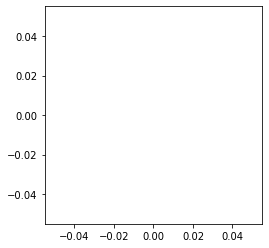

In [176]:
proj_df.plot(a)

In [208]:
pyproj.transform(
    pyproj.Proj("EPSG:4326"), 
    pyproj.Proj(f"+proj=aeqd +units=km +lat_0={start_lat} +lon_0={start_lon}"), 
#     shapely.geometry.Point(start_lon, start_lat)
    29.92712, -95.62672
)

/tmp/ipykernel_150171/2189351546.py:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  pyproj.transform(


(204.3305485478892, -36.113771005486285)

In [181]:
f"+proj=aeqd +units=km +lat_0={start_lat} +lon_0={start_lon}"

'+proj=aeqd +units=km +lat_0=30.27 +lon_0=-97.743'

In [182]:
proj

<Derived Projected CRS: +proj=aeqd +units=km +lat_0=30.27 +lon_0=-97.743 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Modified Azimuthal Equidistant
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [241]:
from functools import partial

import pyproj
from shapely import geometry
from shapely.geometry import Point
from shapely.ops import transform

# lon, lat = -122.431297, 37.773972 # lon lat for San Francisco
# radius = 10000  # in m

local_azimuthal_projection = f"+proj=aeqd +units=km +lat_0={start_lat} +lon_0={start_lon}"
wgs84_to_aeqd = partial(
    pyproj.transform,
    pyproj.Proj("EPSG:4326"),
    pyproj.Proj(local_azimuthal_projection),
)
aeqd_to_wgs84 = partial(
    pyproj.transform,
    pyproj.Proj(local_azimuthal_projection),
    pyproj.Proj("EPSG:4326"),
)

# center = Point(float(lon), float(lat))
# point_transformed = transform(wgs84_to_aeqd, center)
# buffer = point_transformed.buffer(radius)
# Get the polygon with lat lon coordinates
# circle_poly = transform(aeqd_to_wgs84, buffer)

In [261]:
proj_df["geometry"] = proj_df["geometry"].transform(lambda i: Point(wgs84_to_aeqd(i.x, i.y)))

/tmp/ipykernel_150171/1650431364.py:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  proj_df["geometry"] = proj_df["geometry"].transform(lambda i: Point(wgs84_to_aeqd(i.x, i.y)))


In [266]:
proj_df["distance"] = proj_df["geometry"].distance(Point(0, 0))

/tmp/ipykernel_150171/3214616330.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  proj_df["distance"] = proj_df["geometry"].distance(Point(0, 0))


In [267]:
proj_df.query("name == 'Austin'")

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,...,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date,geometry,distance
125941,4671654,Austin,Austin,"AUS,Austin,Austino,Austinopolis,Aŭstino,Montop...",30.26715,-97.74306,P,PPLA,US,NaN,...,453,NaN,NaN,931830,149.0,165,America/Chicago,2019-09-05,POINT (-0.00577 -0.31594),0.315995


In [268]:
proj_df.sort_values("distance").head(20)

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,...,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date,geometry,distance
125941,4671654,Austin,Austin,"AUS,Austin,Austino,Austinopolis,Aŭstino,Montop...",30.26715,-97.74306,P,PPLA,US,NaN,...,453,NaN,NaN,931830,149.0,165,America/Chicago,2019-09-05,POINT (-0.00577 -0.31594),0.315995
126576,4723734,Rollingwood,Rollingwood,NaN,30.27687,-97.79112,P,PPL,US,NaN,...,453,NaN,NaN,1543,197.0,203,America/Chicago,2017-03-09,POINT (-4.62998 0.76257),4.692355
126724,4740928,West Lake Hills,West Lake Hills,NaN,30.29798,-97.80195,P,PPL,US,NaN,...,453,NaN,NaN,3317,238.0,252,America/Chicago,2017-03-09,POINT (-5.67080 3.10326),6.464374
126378,4708016,Lost Creek,Lost Creek,NaN,30.29548,-97.84445,P,PPL,US,NaN,...,453,NaN,NaN,4509,251.0,257,America/Chicago,2011-05-14,POINT (-9.75940 2.82900),10.161161
125952,4672494,Barton Creek,Barton Creek,NaN,30.28521,-97.86917,P,PPL,US,NaN,...,453,NaN,NaN,3077,250.0,252,America/Chicago,2011-05-14,POINT (-12.13871 1.69288),12.256187
126477,4716734,Onion Creek,Onion Creek,NaN,30.13660,-97.78417,P,PPL,US,NaN,...,453,NaN,NaN,2116,175.0,184,America/Chicago,2006-01-15,POINT (-3.96689 -14.78746),15.310294
126250,4698809,Hornsby Bend,Hornsby Bend,"Dunlap,Hornsby,Hornsby Bend",30.24743,-97.58333,P,PPL,US,NaN,...,453,NaN,NaN,6791,135.0,139,America/Chicago,2011-05-14,POINT (15.36760 -2.49125),15.568217
126625,4728052,Shady Hollow,Shady Hollow,NaN,30.16493,-97.86223,P,PPL,US,NaN,...,453,NaN,NaN,5004,229.0,234,America/Chicago,2011-05-14,POINT (-11.48499 -11.64163),16.353370
126390,4708936,Manchaca,Manchaca,NaN,30.14077,-97.83306,P,PPL,US,NaN,...,453,NaN,NaN,1133,214.0,220,America/Chicago,2011-05-14,POINT (-8.67727 -14.32248),16.745995
126286,4701458,Jollyville,Jollyville,NaN,30.44270,-97.77501,P,PPL,US,NaN,...,491,NaN,NaN,16151,286.0,291,America/Chicago,2011-05-14,POINT (-3.07473 19.14569),19.391015


In [228]:
help(gpd)

Help on package geopandas:

NAME
    geopandas

PACKAGE CONTENTS
    _compat
    _config
    _decorator
    _vectorized
    _version
    array
    base
    conftest
    datasets (package)
    explore
    geodataframe
    geoseries
    io (package)
    plotting
    sindex
    testing
    tests (package)
    tools (package)

DATA
    options = Options(
      display_precision: None [default: Non...USE_PYGEO...

VERSION
    0.10.2

FILE
    /home/matt/development/models/refuge-routes-model/.venv/lib/python3.8/site-packages/geopandas/__init__.py


